In [3]:
import os, sys
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import json
# import mpl_stylesheet
sys.path.append("../../utils")
import utils
# mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 14, 
#                                    colors = 'banskt', dpi = 300, black = '#9ea8ad')

In [17]:
tissue_file = '../../plots/tissue_table.txt'
json_file = '../../gtex_v8_metadata.json'
#nsample_file = '../results/gtex/tissue_nsamples.txt'

runtypes = ["gtex_v8_eur_noADM_30pc", "gtex_v8_eur_noADM"]
runtype  = runtypes[1]
a2t_dir = f'../../../sb_optimization/{runtype}'

In [18]:
tshorts, tfulls, tstrings = utils.read_tissues_str(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
tissue_nsamples = dict()

for tshort, tfull, tstring in zip(tshorts, tfulls, tstrings):
    if tshort in tshorts:
        tissue_names[tshort] = tstring
        tissue_colors[tshort] = "#" + gtex_meta[tfull]["colorHex"]
        tissue_nsamples[tshort] = gtex_meta[tfull]["rnaSeqSampleCount"]
        
brain_tissues = ['bam', 'ban', 'bca', 'bceh', 'bce', 'bco', 'bfr', 'bhi', 'bhy', 'bnu', 'bpu', 'bsp', 'bsu']
# sb006_tissues = ['ag', 'colt', 'haa', 'liv', 'msg', 'pan', 'pit', 'pro', 'si', 'spl', 'va', 'wb']
sb006_tissues = ['ag', 'haa', 'liv', 'msg', 'pan', 'pit', 'si', 'spl', 'va', 'wb']
sb006_tissues = ['haa', 'pan', 'spl', 'wb']

In [19]:
OPTPATH_FIELDS = ['sbeta', 'ngp', 'qvar']
class OptPath(collections.namedtuple('_OptPath', OPTPATH_FIELDS)):
    __slots__ = ()
    
def read_sboptim_results(infile):
    sbpath = list()
    with open(infile, 'r') as instream:
        #sboptim = float(instream.readline().strip().split()[0])
        for line in instream:
            lsplit = line.strip().split('\t')
            sbeta = float(lsplit[0].strip())
            kurt = float(lsplit[1].strip())
            qvar = float(lsplit[2].strip())
            sbinstance = OptPath(sbeta = sbeta, ngp = abs(kurt), qvar = qvar)
            sbpath.append(sbinstance)
    return sbpath

def optimum_sigbeta(res, shift = 0.05):
    ngp = np.array([x.ngp for x in res])
    qvar = np.array([x.qvar for x in res])
    sbeta = np.array([x.sbeta for x in res])
    ngp_diff = ngp - np.min(ngp)
    min_sbeta = sbeta[np.argmin(ngp)]
    
    maskngp = ngp_diff <= shift
    maskqvr = qvar >= 0.005
    mask = np.logical_and(maskngp, maskqvr)
    if np.sum(mask) > 0:
        opt_sbeta = np.max(sbeta[mask])
    else:
        opt_sbeta = np.nan
        
    return opt_sbeta

In [20]:
res = dict()
for t in tshorts:
    tfile = os.path.join(a2t_dir, f'{t}_sboptim.txt')
    if os.path.exists(tfile):
        res[t] = read_sboptim_results(tfile)

In [21]:
whichtissues = [x for x in tshorts if x in res.keys() and x not in sb006_tissues]
fileprefix = f'gtex_alpha2t_sb01_tissues_{runtype}'
subplot_h = 1.8

# whichtissues = [x for x in tshorts if x in res.keys() and x in sb006_tissues]
# fileprefix = f'gtex_alpha2t_sb006_tissues_{runtype}'
# subplot_h = 1.8

bgcolor = '#F0F0F0'
highlight_color = '#EE6868'
subdue_color = '#848f94'
text_color = '#69767c'

nplot = len(whichtissues)
ncol  = 6
nrow  = int(nplot / ncol + 1) if nplot%ncol != 0 else int(nplot / ncol)
figw  = ncol * subplot_h + (ncol - 1) * 0.3 + 1.2
figh  = nrow * subplot_h + (nrow - 1) * 0.3 + 1.5

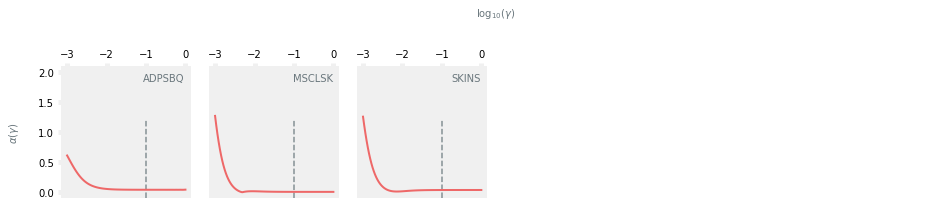

In [22]:
fig = plt.figure(figsize = (figw, figh))
# sigbeta_choices = [0.1, 0.006]
# tlist_sb = [list() for x in sigbeta_choices]
axmain = fig.add_subplot(111)

for i, tshort in enumerate(whichtissues):
    ax = fig.add_subplot(nrow, ncol, i + 1)
    sbeta = [np.log10(x.sbeta) for x in res[tshort]]
    ngp   = [x.ngp for x in res[tshort]]
    ax.plot(sbeta, ngp, lw = 2, color = highlight_color, zorder = 5)
    
#     opt_sbeta = optimum_sigbeta(res[tshort], shift = 0.05)
#     if not np.isnan(opt_sbeta):
#         sbeta_choose_idx = np.argmin(np.array([abs(x - opt_sbeta) for x in sigbeta_choices]))
#         tlist_sb[sbeta_choose_idx].append(tshort)
#         ax.axvline(np.log10(sigbeta_choices[sbeta_choose_idx]), ymax = 0.6, color = subdue_color, ls = 'dashed')

    opt_sbeta = 0.1 if tshort not in sb006_tissues else 0.006
    ax.axvline(np.log10(opt_sbeta), ymax = 0.6, color = subdue_color, ls = 'dashed')
    
    ax.text(0.95, 0.95, tissue_names[tshort], va='top', ha='right', transform=ax.transAxes, color = text_color)
    ax.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
    
    ax.set_facecolor(bgcolor)
    for side, border in ax.spines.items():
        border.set_visible(False)
    if i < ncol:
        ax.tick_params(top = True, labeltop = True, color = bgcolor, width = 5)
        ax.set_xticks(np.log10([0.001, 0.01, 0.1, 1.0]))
    if i%ncol == 0:
        ax.tick_params(left = True, labelleft = True, color = bgcolor, width = 5)
    ax.set_ylim(-0.1, 2.1)
    
axmain.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
for side, border in axmain.spines.items():
    border.set_visible(False)
axmain.set_ylabel(r'$\alpha(\gamma)$', labelpad = 40, color = text_color)
axmain.set_xlabel('$\log_{10}(\gamma)$', labelpad = 50, color = text_color)
axmain.xaxis.set_label_position('top') 


plt.tight_layout()
plt.savefig(f'{fileprefix}.pdf', bbox_inches='tight')
plt.savefig(f'{fileprefix}.png', bbox_inches='tight')
plt.show()

In [23]:
from operator import attrgetter
print(sorted(res['ms'], key=attrgetter('ngp'))[:3])
print(sorted(res['as'], key=attrgetter('ngp'))[:3])

[OptPath(sbeta=0.004977023564332114, ngp=0.0018341105130091906, qvar=0.6672129031938117), OptPath(sbeta=0.004641588833612782, ngp=0.00392728112262497, qvar=0.722535767383328), OptPath(sbeta=0.005336699231206312, ngp=0.006425417386160426, qvar=0.6370935388838573)]
[OptPath(sbeta=0.8697490026177834, ngp=0.041878518939846066, qvar=4.063030278012632e-05), OptPath(sbeta=0.8111308307896873, ngp=0.04204127311957606, qvar=4.6712322301261515e-05), OptPath(sbeta=0.5336699231206312, ngp=0.04207390485005735, qvar=0.00010790595885389265)]


#### Legacy plot below, do not delete.
On the y-axis we plotted NGP (left axis, red) and std of the Var<Qscale> (right axis, black dotted)

In [ ]:
fig = plt.figure(figsize = (figw, figh))

for i, tshort in enumerate(whichtissues):
    ax = fig.add_subplot(nrow, ncol, i + 1)
    sbeta = [np.log10(x.sbeta) for x in res[tshort]]
    ngp   = [x.ngp for x in res[tshort]]
    qvar  = [np.log10(x.qvar) for x in res[tshort]]
    ax.plot(sbeta, ngp, lw = 2, color = highlight_color, zorder = 5)
    axt = ax.twinx()
    axt.plot(sbeta, qvar, lw = 1, color = subdue_color, zorder = 0, ls = ':')
    axt.axhline(np.log10(0.005), color = subdue_color, lw = 1, zorder = 0, ls = 'dashed')
    
    opt_sbeta = optimum_sigbeta(res[tshort])
    #ax.scatter(sbeta, ngp, s = 5, color = '#367dc4', zorder = 10)
    if not np.isnan(opt_sbeta):
        ax.axvline(np.log10(opt_sbeta), ymax = 0.6, color = highlight_color, ls = 'dashed')
    #ax.axvline(np.log10(0.1), color = '#d5dadc', ls = 'dashed')
    
    ax.text(0.95, 0.95, tissue_names[tshort], va='top', ha='right', transform=ax.transAxes, color = text_color)
    ax.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
    axt.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
    
    ax.set_facecolor(bgcolor)
    for side, border in ax.spines.items():
        border.set_visible(False)
    for side, border in axt.spines.items():
        border.set_visible(False)
    
    if i < ncol:
        ax.tick_params(top = True, labeltop = True, color = bgcolor, width = 5)
        ax.set_xticks(np.log10([0.001, 0.01, 0.1, 1.0]))
    if i%ncol == 0:
        ax.tick_params(left = True, labelleft = True, color = bgcolor, width = 5)
    if i%ncol == (ncol - 1):
        axt.tick_params(right = True, labelright = True, color = bgcolor, width = 5)
        #axt.set_yticks([-10, -5, 0])
    ax.set_ylim(-0.1, 2.1)
    axt.set_ylim(-4.2, 0.2)
    

plt.tight_layout()
# plt.savefig('../gtex_protein_coding_sbeta_optimization.pdf', bbox_inches='tight')
# plt.savefig('../gtex_protein_coding_sbeta_optimization.png', bbox_inches='tight')
plt.show()